In [1]:
# -*- encoding: utf-8 -*-
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
# import argparse
from torch.utils import data
from torch.utils.data import Dataset

from utils import pad, VOCAB, tag2idx, idx2tag,MAX_LEN,save_model,load_model

#加载自定义模型
from modules.BBC import Bert_BiGRU_CRF
from crf import Bert_BiLSTM_CRF
from modules.BIC import BiGRU_CRF,BiLSTM_CRF
from modules.BC import Bert_CRF
from modules.ABC import ALNET_BiGRU_CRF
from modules.RBC import ROBERTA_BiGRU_CRF
from modules.BBAC import Bert_BiGRU_Attention_CRF

import matplotlib.pyplot as plt

from pytorch_pretrained_bert import BertTokenizer
# from pytorch_transformers import RobertaTokenizer,BertTokenizer
from pytorch_transformers import RobertaTokenizer
from pytorch_transformers import XLNetModel,XLNetTokenizer

# 用来加载日志
import datetime
import logging


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("use device:",device)

use device: cuda


In [3]:
LOGPATH="./logs/allmin_v1_"+datetime.datetime.now().strftime('%Y-%m-%d')+".log"
LOGPATH

'./logs/allmin_v1_2021-08-12.log'

In [4]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(name)s %(levelname)s %(message)s",
#                     datefmt='%a %d %b %Y %H:%M:%S',
                    filename=LOGPATH
                    )
logger = logging.getLogger(__name__)

## 自定义Bert系列模型数据

In [5]:
class NerDataset(Dataset):
    def __init__(self, f_path):
        self.tokenizer = BertTokenizer.from_pretrained('chinese_L-12_H-768_A-12')
        with open(f_path, 'r', encoding='utf-8') as fr:
            entries = fr.read().strip().split('\n\n')
        sents, tags_li = [], [] # list of lists
        for entry in entries:
            words = [line.split()[0] for line in entry.splitlines()]
            tags = ([line.split()[-1] for line in entry.splitlines()])
            if len(words) > MAX_LEN:
                # 先对句号分段
                word, tag = [], []
                for char, t in zip(words, tags):
                    
                    if char != '。':
                        if char != '\ue236':   # 测试集中有这个字符
                            word.append(char)
                            tag.append(t)
                    else:
                        sents.append(["[CLS]"] + word[:MAX_LEN] + ["[SEP]"])
                        tags_li.append(['[CLS]'] + tag[:MAX_LEN] + ['[SEP]'])
                        word, tag = [], []            
                # 最后的末尾
                if len(word):
                    sents.append(["[CLS]"] + word[:MAX_LEN] + ["[SEP]"])
                    tags_li.append(['[CLS]'] + tag[:MAX_LEN] + ['[SEP]'])
                    word, tag = [], []
            else:
                sents.append(["[CLS]"] + words[:MAX_LEN] + ["[SEP]"])
                tags_li.append(['[CLS]'] + tags[:MAX_LEN] + ['[SEP]'])
        self.sents, self.tags_li = sents, tags_li
                

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx]
        x, y = [], []
        is_heads = []
        for w, t in zip(words, tags):
            tokens = self.tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = self.tokenizer.convert_tokens_to_ids(tokens)
            # assert len(tokens) == len(xx), f"len(tokens)={len(tokens)}, len(xx)={len(xx)}"

            # 中文没有英文wordpiece后分成几块的情况
            is_head = [1] + [0]*(len(tokens) - 1)
            t = [t] + ['<PAD>'] * (len(tokens) - 1)
            yy = [tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)
        assert len(x)==len(y)==len(is_heads), f"len(x)={len(x)}, len(y)={len(y)}, len(is_heads)={len(is_heads)}"

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen


    def __len__(self):
        return len(self.sents)

## 自定义RoBERTa模型数据

In [6]:
class RoBERTaDataset(Dataset):
    def __init__(self, f_path):
        self.tokenizer = BertTokenizer.from_pretrained("./chinese_roberta_wwm_ext_pytorch/")
        
        with open(f_path, 'r', encoding='utf-8') as fr:
            entries = fr.read().strip().split('\n\n')
        sents, tags_li = [], [] # list of lists
        for entry in entries:
            words = [line.split()[0] for line in entry.splitlines()]
            tags = ([line.split()[-1] for line in entry.splitlines()])
            if len(words) > MAX_LEN:
                # 先对句号分段
                word, tag = [], []
                for char, t in zip(words, tags):
                    
                    if char != '。':
                        if char != '\ue236':   # 测试集中有这个字符
                            word.append(char)
                            tag.append(t)
                    else:
                        sents.append(["[CLS]"] + word[:MAX_LEN] + ["[SEP]"])
                        tags_li.append(['[CLS]'] + tag[:MAX_LEN] + ['[SEP]'])
                        word, tag = [], []            
                # 最后的末尾
                if len(word):
                    sents.append(["[CLS]"] + word[:MAX_LEN] + ["[SEP]"])
                    tags_li.append(['[CLS]'] + tag[:MAX_LEN] + ['[SEP]'])
                    word, tag = [], []
            else:
                sents.append(["[CLS]"] + words[:MAX_LEN] + ["[SEP]"])
                tags_li.append(['[CLS]'] + tags[:MAX_LEN] + ['[SEP]'])
        self.sents, self.tags_li = sents, tags_li
                

    def __getitem__(self, idx):
        
        words, tags = self.sents[idx], self.tags_li[idx]
        x, y = [], []
        is_heads = []
        for w, t in zip(words, tags):
            tokens = self.tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = self.tokenizer.convert_tokens_to_ids(tokens)
            # assert len(tokens) == len(xx), f"len(tokens)={len(tokens)}, len(xx)={len(xx)}"

            # 中文没有英文wordpiece后分成几块的情况
            is_head = [1] + [0]*(len(tokens) - 1)
            t = [t] + ['<PAD>'] * (len(tokens) - 1)
            yy = [tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)
        assert len(x)==len(y)==len(is_heads), f"len(x)={len(x)}, len(y)={len(y)}, len(is_heads)={len(is_heads)}"

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen


    def __len__(self):
        return len(self.sents)

## 自定义XLNet模型数据

In [7]:
class XlNetDataset(Dataset):
    def __init__(self, f_path):
        self.tokenizer = XLNetTokenizer.from_pretrained('chinese_xlnet_base_pytorch')
        with open(f_path, 'r', encoding='utf-8') as fr:
            entries = fr.read().strip().split('\n\n')
        sents, tags_li = [], [] # list of lists
        for entry in entries:
            words = [line.split()[0] for line in entry.splitlines()]
            tags = ([line.split()[-1] for line in entry.splitlines()])
            if len(words) > MAX_LEN:
                # 先对句号分段
                word, tag = [], []
                for char, t in zip(words, tags):
                    
                    if char != '。':
                        if char != '\ue236':   # 测试集中有这个字符
                            word.append(char)
                            tag.append(t)
                    else:
                        sents.append(["[CLS]"] + word[:MAX_LEN] + ["[SEP]"])
                        tags_li.append(['[CLS]'] + tag[:MAX_LEN] + ['[SEP]'])
                        word, tag = [], []            
                # 最后的末尾
                if len(word):
                    sents.append(["[CLS]"] + word[:MAX_LEN] + ["[SEP]"])
                    tags_li.append(['[CLS]'] + tag[:MAX_LEN] + ['[SEP]'])
                    word, tag = [], []
            else:
                sents.append(["[CLS]"] + words[:MAX_LEN] + ["[SEP]"])
                tags_li.append(['[CLS]'] + tags[:MAX_LEN] + ['[SEP]'])
        self.sents, self.tags_li = sents, tags_li
                

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx]
        x, y = [], []
        is_heads = []
        for w, t in zip(words, tags):
            tokens = self.tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = self.tokenizer.convert_tokens_to_ids(tokens)
            # assert len(tokens) == len(xx), f"len(tokens)={len(tokens)}, len(xx)={len(xx)}"

            # 中文没有英文wordpiece后分成几块的情况
            is_head = [1] + [0]*(len(tokens) - 1)
            t = [t] + ['<PAD>'] * (len(tokens) - 1)
            yy = [tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)
        assert len(x)==len(y)==len(is_heads), f"len(x)={len(x)}, len(y)={len(y)}, len(is_heads)={len(is_heads)}"

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen


    def __len__(self):
        return len(self.sents)

In [8]:
def train(model, iterator, optimizer, criterion, device):
    model.train()
    for i, batch in enumerate(iterator):
        words, x, is_heads, tags, y, seqlens = batch
        x = x.to(device)
        y = y.to(device)
        _y = y # for monitoring
        optimizer.zero_grad()
        loss = model.neg_log_likelihood(x, y) # logits: (N, T, VOCAB), y: (N, T)

        # logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
        # y = y.view(-1)  # (N*T,)
        # writer.add_scalar('data/loss', loss.item(), )

        # loss = criterion(logits, y)
        loss.backward()

        optimizer.step()

        # if i==0:
        #     print("=====sanity check======")
        #     #print("words:", words[0])
        #     print("x:", x.cpu().numpy()[0][:seqlens[0]])
        #     # print("tokens:", tokenizer.convert_ids_to_tokens(x.cpu().numpy()[0])[:seqlens[0]])
        #     print("is_heads:", is_heads[0])
        #     print("y:", _y.cpu().numpy()[0][:seqlens[0]])
        #     print("tags:", tags[0])
        #     print("seqlen:", seqlens[0])
        #     print("=======================")

        if i%100==0: # monitoring
            print(f"step: {i}, loss: {loss.item()}")

In [9]:
from os.path import join
from codecs import open
from collections import Counter

def count_correct_tags(gold_lists,pre_lists):
    """计算每种标签预测正确的个数(对应精确率、召回率计算公式上的tp)，用于后面精确率以及召回率的计算"""
    correct_dict = {}

    for gold_tag, predict_tag in zip(gold_lists, pre_lists):
        if gold_tag == predict_tag:
            if gold_tag not in correct_dict:
                correct_dict[gold_tag] = 1
            else:
                correct_dict[gold_tag] += 1

    return correct_dict



def cal_precision(pre_tags_counter,correct_tags_number,tagset):
    precision_scores = {}
    for tag in tagset:
        if pre_tags_counter[tag] == 0:
            precision_scores[tag] = 0
        else:
            precision_scores[tag] = correct_tags_number.get(tag, 0) / \
                                    pre_tags_counter[tag]

    return precision_scores


def cal_recall(golden_tags_counter,correct_tags_number,tagset):
    recall_scores = {}
    for tag in tagset:
        recall_scores[tag] = correct_tags_number.get(tag, 0) / \
                             golden_tags_counter[tag]
    return recall_scores


def cal_f1(precision_scores,recall_scores,tagset):
    f1_scores = {}
    for tag in tagset:
        p, r = precision_scores[tag], recall_scores[tag]
        f1_scores[tag] = 2 * p * r / (p + r + 1e-10)  # 加上一个特别小的数，防止分母为0
    return f1_scores


def report_scores(precision_scores,recall_scores,f1_scores,golden_tags_counter,gold_lists,tagset):
    """将结果用表格的形式打印出来，像这个样子：

                  precision    recall  f1-score   support
          B-LOC      0.775     0.757     0.766      1084
          I-LOC      0.601     0.631     0.616       325
         B-MISC      0.698     0.499     0.582       339
         I-MISC      0.644     0.567     0.603       557
          B-ORG      0.795     0.801     0.798      1400
          I-ORG      0.831     0.773     0.801      1104
          B-PER      0.812     0.876     0.843       735
          I-PER      0.873     0.931     0.901       634

      avg/total      0.779     0.764     0.770      6178
    """
    # 打印表头
    header_format = '{:>9s}  {:>9} {:>9} {:>9} {:>9}'
    header = ['precision', 'recall', 'f1-score', 'support']
    print(header_format.format('', *header))

    row_format = '{:>9s}  {:>9.4f} {:>9.4f} {:>9.4f} {:>9}'
    # 打印每个标签的 精确率、召回率、f1分数
    for tag in tagset:
        print(row_format.format(
            tag,
            precision_scores[tag],
            recall_scores[tag],
            f1_scores[tag],
            golden_tags_counter[tag]
        ))

    # 计算并打印平均值
    avg_metrics = cal_weighted_average(precision_scores,recall_scores,f1_scores,golden_tags_counter,gold_lists,tagset)
    print(row_format.format(
        'avg/total',
        avg_metrics['precision'],
        avg_metrics['recall'],
        avg_metrics['f1_score'],
        len(gold_lists)
    ))


def cal_weighted_average(precision_scores,recall_scores,f1_scores,golden_tags_counter,gold_lists,tagset):
    weighted_average = {}
    total = len(gold_lists)

    # 计算weighted precisions:
    weighted_average['precision'] = 0.
    weighted_average['recall'] = 0.
    weighted_average['f1_score'] = 0.
    for tag in tagset:
        size = golden_tags_counter[tag]
        weighted_average['precision'] += precision_scores[tag] * size
        weighted_average['recall'] += recall_scores[tag] * size
        weighted_average['f1_score'] += f1_scores[tag] * size

    for metric in weighted_average.keys():
        weighted_average[metric] /= total

    return weighted_average


def remove_Otags(gold_lists,pre_lists):

    length = len(gold_lists)

    O_tag_indices = [i for i in range(length)
                     if gold_lists[i] == 'O']

    gold_lists = [tag for i, tag in enumerate(gold_lists)
                        if i not in O_tag_indices]

    pre_lists = [tag for i, tag in enumerate(pre_lists)
                         if i not in O_tag_indices]
    print("原总标记数为{}，移除了{}个O标记，占比{:.2f}%".format(
        length,
        len(O_tag_indices),
        len(O_tag_indices) / length * 100
    ))

    return gold_lists,pre_lists

def get_entities(seq):
    """
    Gets entities from sequence.

    Args:
        seq (list): sequence of labels.

    Returns:
        list: list of (chunk_type, chunk_start, chunk_end).

    Example:
        seq = ['B-PER', 'I-PER', 'O', 'B-LOC']
        get_entities(seq)
        [('PER', 0, 1), ('LOC', 3, 3)]
    """
    # for nested list
    if any(isinstance(s, list) for s in seq):
        seq = [item for sublist in seq for item in sublist + ['O']]
    prev_tag = 'O'
    prev_type = ''
    begin_offset = 0
    chunks = []
    for i, chunk in enumerate(seq + ['O']):
        tag = chunk[0]
        type_ = chunk.split('-')[-1]

        if end_of_chunk(prev_tag, tag, prev_type, type_):
            chunks.append((prev_type, begin_offset, i - 1))
        if start_of_chunk(prev_tag, tag, prev_type, type_):
            begin_offset = i
        prev_tag = tag
        prev_type = type_

    return chunks


def end_of_chunk(prev_tag, tag, prev_type, type_):
    """Checks if a chunk ended between the previous and current word.

    Args:
        prev_tag: previous chunk tag.
        tag: current chunk tag.
        prev_type: previous type.
        type_: current type.

    Returns:
        chunk_end: boolean.
    """
    chunk_end = False

    if prev_tag == 'S':
        chunk_end = True
    if prev_tag == 'E':
        chunk_end = True
    # pred_label中可能出现这种情形
    if prev_tag == 'B' and tag == 'B':
        chunk_end = True
    if prev_tag == 'B' and tag == 'S':
        chunk_end = True
    if prev_tag == 'B' and tag == 'O':
        chunk_end = True
    if prev_tag == 'M' and tag == 'B':
        chunk_end = True
    if prev_tag == 'M' and tag == 'S':
        chunk_end = True
    if prev_tag == 'M' and tag == 'O':
        chunk_end = True

    if prev_tag != 'O' and prev_tag != '.' and prev_type != type_:
        chunk_end = True

    return chunk_end


def start_of_chunk(prev_tag, tag, prev_type, type_):
    """Checks if a chunk started between the previous and current word.

    Args:
        prev_tag: previous chunk tag.
        tag: current chunk tag.
        prev_type: previous type.
        type_: current type.

    Returns:
        chunk_start: boolean.
    """
    chunk_start = False

    if tag == 'B':
        chunk_start = True
    if tag == 'S':
        chunk_start = True

    if prev_tag == 'S' and tag == 'M':
        chunk_start = True
    if prev_tag == 'O' and tag == 'M':
        chunk_start = True
    if prev_tag == 'S' and tag == 'E':
        chunk_start = True
    if prev_tag == 'O' and tag == 'E':
        chunk_start = True

    if tag != 'O' and tag != '.' and prev_type != type_:
        chunk_start = True

    return chunk_start


def f1_score(y_true, y_pred, labels, mode='dev'):

    true_entities = set(get_entities(y_true))
    pred_entities = set(get_entities(y_pred))
    nb_correct = len(true_entities & pred_entities)
    nb_pred = len(pred_entities)
    nb_true = len(true_entities)

    true_entities_num = {'NAME': 0, 'TYPE': 0, 'ENV': 0, 'FEA': 0, 'SUR': 0, 'EVA': 0, 'DEF': 0}
    for entity in true_entities:
        tag = entity[0]
        true_entities_num[tag] += 1

    p = nb_correct / nb_pred if nb_pred > 0 else 0
    r = nb_correct / nb_true if nb_true > 0 else 0
    score = 2 * p * r / (p + r) if p + r > 0 else 0
    if mode == 'dev':
        return score
    else:
        f_score = {}
        precision_scores = {}
        recall_scores = {}
        for label in labels:
            true_entities_label = set()
            pred_entities_label = set()
            for t in true_entities:
                if t[0] == label:
                    true_entities_label.add(t)
            for p in pred_entities:
                if p[0] == label:
                    pred_entities_label.add(p)
            nb_correct_label = len(true_entities_label & pred_entities_label)
            nb_pred_label = len(pred_entities_label)
            nb_true_label = len(true_entities_label)

            p_label = nb_correct_label / nb_pred_label if nb_pred_label > 0 else 0
            r_label = nb_correct_label / nb_true_label if nb_true_label > 0 else 0
            score_label = 2 * p_label * r_label / (p_label + r_label) if p_label + r_label > 0 else 0
            f_score[label] = score_label
            precision_scores[label] = p_label
            recall_scores[label] = r_label

        weighted_average = {}
        total = nb_true

        # 计算weighted precisions:
        weighted_average['precision'] = 0.
        weighted_average['recall'] = 0.
        weighted_average['f1_score'] = 0.
        for tag in labels:
            size = true_entities_num[tag]
            weighted_average['precision'] += precision_scores[tag] * size
            weighted_average['recall'] += recall_scores[tag] * size
            weighted_average['f1_score'] += f_score[tag] * size

        for metric in weighted_average.keys():
            weighted_average[metric] /= total

        header_format = '{:>9s}  {:>9} {:>9} {:>9} {:>9}'
        header = ['precision', 'recall', 'f1-score', 'support']
        print("-------------------Entities Report------------------")
        print(header_format.format('', *header))

        row_format = '{:>9s}  {:>9.4f} {:>9.4f} {:>9.4f} {:>9}'
        # 打印每个标签的 精确率、召回率、f1分数
        for tag in labels:
            print(row_format.format(
                tag,
                precision_scores[tag],
                recall_scores[tag],
                f_score[tag],
                true_entities_num[tag]
            ))
        print(row_format.format(
            'avg/total',
            weighted_average['precision'],
            weighted_average['recall'],
            weighted_average['f1_score'],
            total
        ))
        print("-------------------Labels Report----- -------------")

        return f_score, score

In [10]:
def eval(model, iterator, f, device,temp:str, isEnd=False):
#     print("temp:"+temp)
    model.eval()

    Words, Is_heads, Tags, Y, Y_hat = [], [], [], [], []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words, x, is_heads, tags, y, seqlens = batch
            x = x.to(device)
            # y = y.to(device)

            _, y_hat = model(x)  # y_hat: (N, T)

            Words.extend(words)
            Is_heads.extend(is_heads)
            Tags.extend(tags)
            Y.extend(y.numpy().tolist())
            Y_hat.extend(y_hat.cpu().numpy().tolist())

    ## gets results and save
    with open(temp, 'w', encoding='utf-8') as fout:
        for words, is_heads, tags, y_hat in zip(Words, Is_heads, Tags, Y_hat):
            y_hat = [hat for head, hat in zip(is_heads, y_hat) if head == 1]
            preds = [idx2tag[hat] for hat in y_hat]
            assert len(preds)==len(words.split())==len(tags.split())
            for w, t, p in zip(words.split()[1:-1], tags.split()[1:-1], preds[1:-1]):
                fout.write(f"{w} {t} {p}\n")
            fout.write("\n")

    word_lists = []
    gold_lists = []
    pre_lists = []
    
    with open(temp, 'r', encoding='utf-8') as f:
        for line in f:
            if line != '\n':
                word, gold, pre = line.strip('\n').split()
                #print(word, ' ' + gold, '' + pre)
                word_lists.append(word)
                gold_lists.append(gold)
                pre_lists.append(pre)
    
    
    
    labels = ['NAME', 'TYPE', 'ENV', 'FEA', 'SUR', 'EVA', 'DEF']
    f1_score(gold_lists, pre_lists, labels, mode='test')
    gold_lists,pre_lists=remove_Otags(gold_lists,pre_lists)
    tagset = set(gold_lists)
    correct_tags_number = count_correct_tags(gold_lists,pre_lists)
    pre_tags_counter = Counter(pre_lists)
    golden_tags_counter = Counter(gold_lists)
    precision_scores = cal_precision(pre_tags_counter,correct_tags_number,tagset)
    recall_scores = cal_recall(golden_tags_counter,correct_tags_number,tagset)
    f1_scores = cal_f1(precision_scores,recall_scores,tagset)
    avg = cal_weighted_average(precision_scores,recall_scores,f1_scores,golden_tags_counter,gold_lists,tagset)
    report_scores(precision_scores,recall_scores,f1_scores,golden_tags_counter,gold_lists,tagset)
    

    if isEnd!=True:
        os.remove(temp)

#     print("precision=%.4f"%precision)
#     print("recall=%.4f"%recall)
#     print("f1=%.4f"%f1)
    return avg['precision'],avg['recall'], avg['f1_score']

In [11]:
def run(LOGDIR="checkpoints/01",TRAINSET="data/gqp.train",VALIDSET="data/gqp.dev",TESTSET="data/test.txt.anns",
        BATCH_SIZE=64,LR=5e-5,N_EPOCHS=1000):

    
    PRFS=[]
    modelnames = [
#         "bert_bigru_attention_crf",
                  "bert_bigru_crf",
#                "bert_bilstm_crf"
#                "bilstm_crf",
#                "bigru_crf",
#                "bert_crf",
#                "roberta_bigru_crf",
#                "alnet_bigru_crf"
            ]
    models =  [ 
#                 (Bert_BiGRU_Attention_CRF(tag2idx).to(device),"bert_bigru_attention_crf_temp"),
                (Bert_BiGRU_CRF(tag2idx).to(device),"bert_bigru_crf_temp")
#                (Bert_BiLSTM_CRF(tag2idx).to(device),"bert_bilstm_crf_temp")
#                ,(BiLSTM_CRF(tag2idx).to(device),"bilstm_crf_temp")
#                ,(BiGRU_CRF(tag2idx).to(device),"bigru_crf_temp")
#                ,(Bert_CRF(tag2idx).to(device),"bert_crf_temp")
#                ,(ROBERTA_BiGRU_CRF(tag2idx).to(device),"roberta_bigru_crf_temp")     
#                ,(ALNET_BiGRU_CRF(tag2idx).to(device),"alnet_bigru_crf_temp")
                ]
        
    for index,(currentmodel,currentmodeltemp) in enumerate(models):
        train_iter,eval_iter = None,None
        
        # 根据模型名称加载对应的模型数据
        if modelnames[index] in ["bert_bigru_attention_crf","bert_bigru_crf","bert_bilstm_crf","bigru_crf","bert_crf","bilstm_crf"]:
            train_dataset = NerDataset(TRAINSET)
            eval_dataset = NerDataset(VALIDSET)
            test_dataset = NerDataset(TESTSET)
            train_iter = data.DataLoader(dataset=train_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=8, #3
                                 collate_fn=pad)
            eval_iter = data.DataLoader(dataset=eval_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=8,
                                 collate_fn=pad)
            test_iter = data.DataLoader(dataset=test_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=8,
                                 collate_fn=pad)
            logger.info(f"{modelnames[index]}匹配到NerDataset")
            
        elif modelnames[index] in ["roberta_bigru_crf"]:
            
            train_dataset = RoBERTaDataset(TRAINSET)
            eval_dataset = RoBERTaDataset(VALIDSET)
            train_iter = data.DataLoader(dataset=train_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=8,
                                 collate_fn=pad)
            eval_iter = data.DataLoader(dataset=eval_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=8,
                                 collate_fn=pad)
            test_iter = data.DataLoader(dataset=test_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=8,
                                 collate_fn=pad)
            logger.info(f"{modelnames[index]}匹配到RoBERTaDataset")
            
        elif modelnames[index] in ["alnet_bigru_crf"]:
            train_dataset = XlNetDataset(TRAINSET)
            eval_dataset = XlNetDataset(VALIDSET)
            train_iter = data.DataLoader(dataset=train_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=8,
                                 collate_fn=pad)
            eval_iter = data.DataLoader(dataset=eval_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=8,
                                 collate_fn=pad)
            test_iter = data.DataLoader(dataset=test_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=8,
                                 collate_fn=pad)
            logger.info(f"{modelnames[index]}匹配到XlNetDataset")
        else:
            logger.warning(f"{modelnames[index]}没有匹配到模型的数据")
        
        
        
#         print("="*30+"begin "+ currentmodelname + "="*30)
        optimizer = optim.Adam(currentmodel.parameters(), lr = LR)
        criterion = nn.CrossEntropyLoss(ignore_index=0) 
        for epoch in range(1, N_EPOCHS+1):  # 每个epoch对dev集进行测试
            
            print("=========epoch= {} ===model= {} =========".format(epoch,modelnames[index]))
            train(currentmodel, train_iter, optimizer, criterion, device)
            print("-----------save model= {} ---------------".format(modelnames[index]))
            torch.save(currentmodel.state_dict(), "./savemodels/"+modelnames[index]+".pkl")
            #save_model(currentmodel, "./savemodels/"+modelnames[index]+".pkl")
            if not os.path.exists(LOGDIR): os.makedirs(LOGDIR)
            fname = os.path.join(LOGDIR, str(epoch))
            precision, recall, f1 = eval(currentmodel, eval_iter, fname, device,currentmodeltemp,isEnd=False)
            logger.info("modelname=%s,epoch=%03d,precision=%.4f,recall=%.4f,f1=%.4f"%(modelnames[index],epoch,precision, recall, f1))
            if epoch == N_EPOCHS:
                print("========= Test ===model= {} ============".format(modelnames[index]))
                eval(currentmodel, test_iter, fname, device,currentmodeltemp,isEnd=True)
                PRFS.append([precision, recall, f1])
            
#         print("="*30+"end "+ currentmodelname + "="*30)
    return PRFS

In [12]:

def getStyles():
    import random
    lineStyles = ['-','--','-.',':']
    markers = [
    '.',
    ','
    'o',
    'v',
    '^',
    '<',
    '>',
    '1',
    '2',
    '3',
    '4',
    '8',
    's',
    'p',
    'P',
    '*',
    'h',
    'H',
    '+',
    'x',
    'X',
    'D',
    'd',
    '|',
    '_'
    ]
    return random.choice(markers)+random.choice(lineStyles)
    


def figure(X ,Y
           ,title
           ,name
           ,index=0 # 0:P,1:R,2:F1
           ,legend_loc=4
           ,picspath="./temp.png"
           ,styles=None
          ):
    
    
    
    
    plt.figure(figsize=(10,6)# figsize: 画布大小
           ,dpi=100) # dpi： 像素

    plt.title(title)
    
    for i in range(len(name)):
        if index == 0:
            label = "P of "+ name[i]
        elif index == 1:
            label = "R of "+ name[i]
        elif index == 2:
            label = "F1 of "+ name[i]
    #     plt.plot(batch_sizes,BSS[:,i,0],label="P of "+name[i])
    #     plt.plot(batch_sizes,BSS[:,i,1],label="R of "+name[i])
#         plt.plot(batch_sizes,BSS[:,i,index],label="F1 of " +name[i])
        plt.plot(X,Y[:,i,index],styles[i],label=label)


    plt.xticks(X) # x坐标的刻度
    # plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]) # y坐标的刻度

    plt.legend(loc=legend_loc) # 加上图例，注意使用这个函数必须plot中有label

    plt.savefig(picspath, dpi=300) # 保存图片
    plt.show() # 图形展示


In [13]:
def setPickle(arg,filepath:str):
    import pickle
    with open(filepath,'wb+') as f:#注意此处mode是'wb+'，表示二进制写入
        f.write(pickle.dumps(arg))
def getPickle(filepath:str):
    import os
    import pickle
    if not os.path.exists(filepath):
        raise Exception(f"{filepath}文件不存在!")
    result = None
    with open(filepath,'rb') as f:
        result = pickle.loads(f.read())
    return result

In [14]:
#modelNames = ["bert_bigru_crf","bert_bilstm_crf","bilstm_crf","bigru_crf","bert_crf","roberta_bigru_crf","alnet_bigru_crf"]
modelNames = ["bert_bigru_crf"]

In [ ]:
# 测试迭代次数的相关性
iters=[]
# range(10,210,10)
# current=None
#iterLength=[*range(1,2,1)]
# iterLength=[*range(1,12,2)]
# for thisIter in iterLength:
# #     print(thisIter)
    
#     current=run(LOGDIR="checkpoints/01",TRAINSET="data/train.txt.anns",VALIDSET="data/dev.txt.anns",BATCH_SIZE=20,LR=5e-5,N_EPOCHS=thisIter)
#     iters.append(current)
# # print(iters)
# iters = np.array(iters)
# # iters
current=run(LOGDIR="checkpoints/01",TRAINSET="data/train.txt.anns",VALIDSET="data/dev.txt.anns",TESTSET="data/test.txt.anns",
            BATCH_SIZE=64,LR=5e-5,N_EPOCHS=1000)


=========epoch= 1 ===model= bert_bigru_crf =========
step: 0, loss: 10723.375
step: 100, loss: 9898.818359375
-----------save model= bert_bigru_crf ---------------
-------------------Entities Report------------------
           precision    recall  f1-score   support
     NAME     0.0000    0.0000    0.0000        61
     TYPE     0.0000    0.0000    0.0000       135
      ENV     0.0000    0.0000    0.0000      1691
      FEA     0.0000    0.0000    0.0000      1427
      SUR     0.0000    0.0000    0.0000        59
      EVA     0.0000    0.0000    0.0000       484
      DEF     0.0000    0.0000    0.0000       174
avg/total     0.0000    0.0000    0.0000      4031
-------------------Labels Report----- -------------
原总标记数为102099，移除了86978个O标记，占比85.19%
           precision    recall  f1-score   support
    E-EVA     0.0000    0.0000    0.0000       482
   E-TYPE     0.0000    0.0000    0.0000       134
    B-ENV     0.0000    0.0000    0.0000      1691
   E-NAME     0.0000    0.0000   

In [1]:
# setPickle(iters,"./PICS/variable/iter_5_5e-5.pkl")

In [ ]:
# iters=getPickle("./PICS/variable/iter_5_5e-5.pkl")
# iterLength=[*range(10,210,10)]

In [17]:
styless=[getStyles() for _ in range(len(modelNames))]

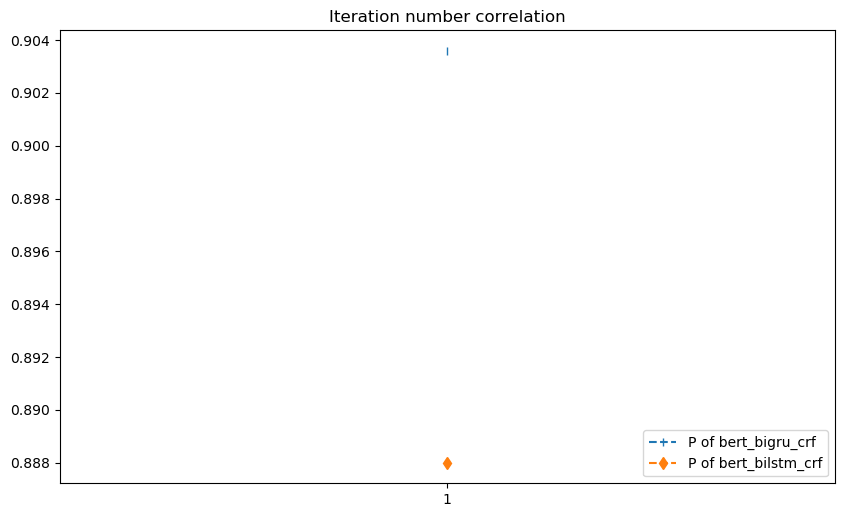

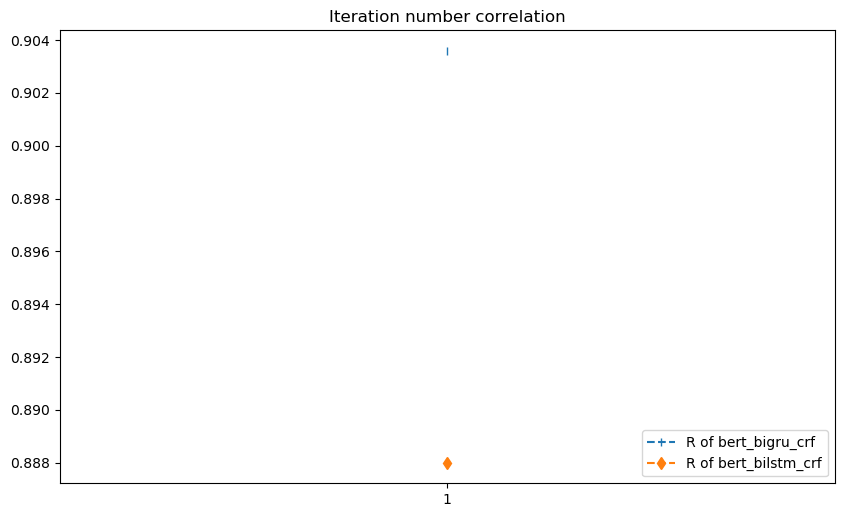

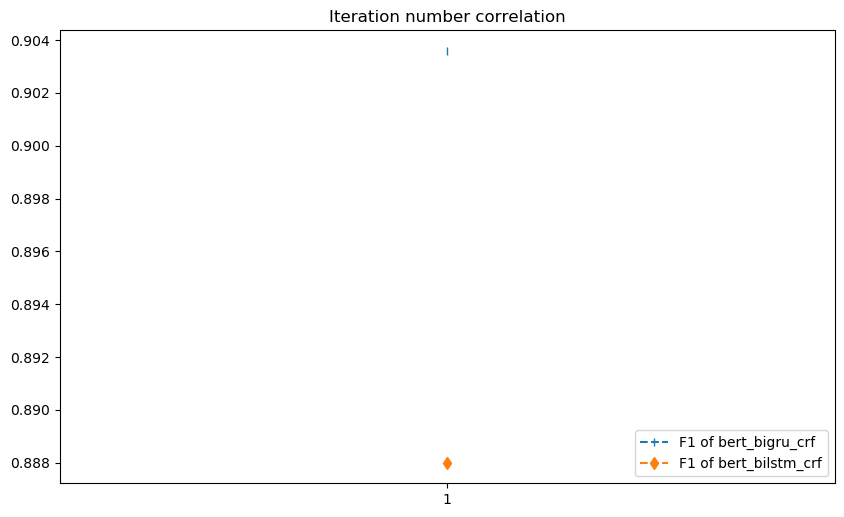

In [18]:
for i in range(3):
    picspath = "./PICS/Iteration_number_correlation_"+datetime.datetime.now().strftime('%Y-%m-%d')+"_"+str(i)+".png"
    figure(X=iterLength ,Y=iters
               ,title="Iteration number correlation"
               ,name=modelNames
               ,index=i # 0:P,1:R,2:F1
               ,legend_loc=4
               ,picspath=picspath
               ,styles=styless
          )

In [21]:
# 批大小相关性研究
# batch_sizes=[*range(10,210,10)]
batch_sizes=[*range(10,110,10)]
BSS=[]
for bs in batch_sizes:
    current=run(LOGDIR="checkpoints/01",TRAINSET="data/gqp.train",VALIDSET="data/gqp.dev",BATCH_SIZE=bs,LR=5e-5,N_EPOCHS=100)
    BSS.append(current)
BSS = np.array(BSS)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


In [22]:
# setPickle(BSS,"./PICS/variable/bss_5e-5_100.pkl")

In [23]:
# BSS=getPickle("./PICS/variable/bss_5e-5_100.pkl")
# batch_sizes=[*range(10,110,10)]

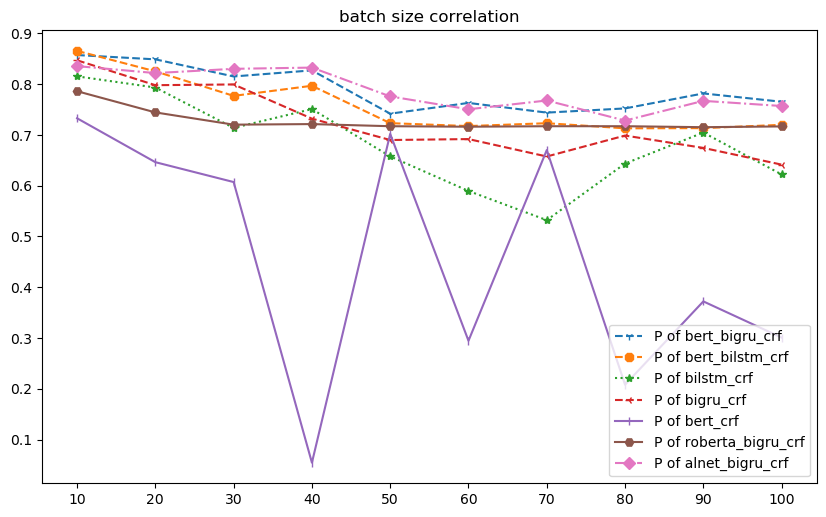

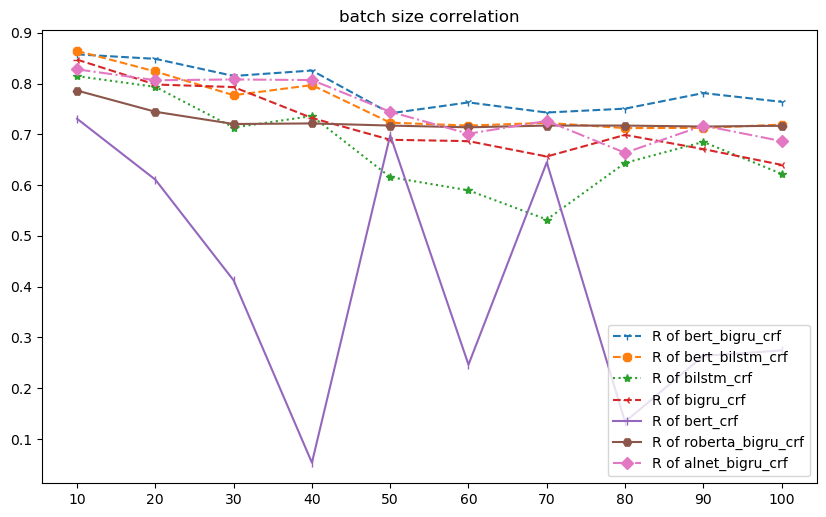

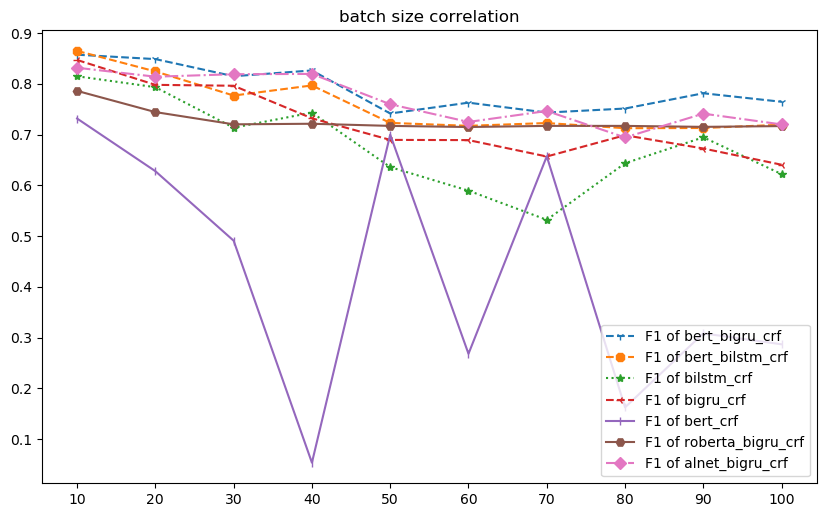

In [24]:
for i in range(3):
    picspath = "./PICS/batch_size_correlation_"+datetime.datetime.now().strftime('%Y-%m-%d')+"_"+str(i)+".png"
    figure(X=batch_sizes ,Y=BSS
               ,title="batch size correlation"
               ,name=modelNames
               ,index=i # 0:P,1:R,2:F1
               ,legend_loc=4
               ,picspath=picspath
           ,styles=styless
          )

In [25]:
# 学习率相关性研究
learn_rates=[1e-1,5e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6]
# learn_rates=[1,1e-1,1e-2]
LRS=[]
for lr in learn_rates:
    current=run(LOGDIR="checkpoints/01",TRAINSET="data/gqp.train",VALIDSET="data/gqp.dev",BATCH_SIZE=5,LR=lr,N_EPOCHS=100)
    LRS.append(current)
LRS = np.array(LRS)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


In [21]:
# setPickle(LRS,"./PICS/variable/lrs_5_100.pkl")

In [34]:
LRS[:,2,1]

array([0.74750958, 0.29042146, 0.80536398, 0.76551724, 0.85823755,
       0.84444444, 0.83409962, 0.84980843, 0.67701149, 0.84061303,
       0.05670498, 0.62605364])

In [35]:
LRS[:,2,2]

array([0.74750958, 0.29042146, 0.80613615, 0.76772334, 0.85823755,
       0.84509202, 0.83409962, 0.85143954, 0.67701149, 0.84061303,
       0.0569669 , 0.62605364])

In [ ]:
for i in range(3):
    import pandas as pd
    lrcsv = pd.DataFrame()
    lrcsv['lr']=learn_rates
    
    for index,name in enumerate(modelNames):
        lrcsv[name] = LRS[:,index,i]
#     lrcsv.round(4)
    if i == 0:
        lrcsv.to_csv("./PICS/lr_p_4.csv",index=False)
    elif i ==1:
        lrcsv.to_csv("./PICS/lr_r_4.csv",index=False)
    elif i ==2:
        lrcsv.to_csv("./PICS/lr_f1_4.csv",index=False)

In [ ]:
current=run(LOGDIR="checkpoints/01",TRAINSET="data/gqp.train",VALIDSET="data/gqp.dev",BATCH_SIZE=10,LR=1e-3,N_EPOCHS=100)